# Simulation using Oscar currents


### Backward simulations within the Oleander domain (Gulf Stream). 

### Bigger domain and for 1 day.



In [2]:
%matplotlib inline
from parcels import Field, FieldSet, ParticleSet, Variable, JITParticle, AdvectionRK4, plotTrajectoriesFile, ErrorCode
import numpy as np
import math
from datetime import timedelta
from operator import attrgetter
from datetime import timedelta as delta

from matplotlib              import dates as mdates
from datetime                import datetime 
import pickle

## Save the outputs in this directory

In [3]:
dirsave    = '/Users/bbarcelo/HOME_SCIENCE/Data/2019_SSS_Ladvection/sim_Oleander_all/sim_outputs/' #save outputs directory

## Oscar data directory

In [4]:
dir_netcdf    = '/Users/bbarcelo/HOME_SCIENCE/Data/2019_SSS/Oscar/' 

file_currents = 'oscar_vel2017.nc'
print(file_currents)

   
# current field file starts at this date, check for each new file the first date in altimetry_check_first_day.py
date_ori = mdates.date2num(datetime(2017, 1, 1, 0, 0, 0))  

oscar_vel2017.nc


## Running times to test

In [5]:
rund = [7, 1] # run times for each simulation

## Define the particles release grid

In [6]:
# DOMAIN FOR OLEANDER SIMULATIONS, BIGGER DOMAIN
lonmin, lonmax = -82, -63 #-74, -66 #-74, -68
latmin, latmax =  25, 46 #35, 40 #37, 40 

dx = 0.04

lons, lats = np.meshgrid(np.arange(360+lonmin, 360+lonmax, dx), np.arange(latmin, latmax, dx))

# we need to have lons, lats and times in a 1d vector (flatten)
lonf, latf = lons.flatten(), lats.flatten()

## Allow particles to leave the domain

Allow particles to leave the domain. We need to tell Parcels that particles that leave the domain need to be deleted. We do that using a `Recovery Kernel`, which will be invoked when a particle encounters an `ErrorOutOfBounds` error:

In [7]:
def DeleteParticle(particle, fieldset, time):
    particle.delete()

## File with the simulation dates

In [8]:
# dir_dic    = '/Users/bbarcelo/HOME_SCIENCE/Data/2019_SSS_Ladvection/'
# file_dic = 'Oleander_TSG_per_transect_all.pkl'

# f = open(dir_dic + file_dic, 'rb')
# dict_tsg_all = pickle.load(f)
# f.close() 

# dates_strings_all = list(dict_tsg_all.keys())
# #print(dates_strings_all)

# # For now, don't do '20180111' simulations

# dates_strings = dates_strings_all.copy()[:-14] #after 2019-01-12 we don't have dt altimetry data
# dates_strings.sort(key=int)
# print(dates_strings)

# only 1 day 
date_sim     = ['20170212'] 
print(date_sim)

['20170212']


## Loop, do simulations for each date in the list

In [9]:
for date in date_sim: #dates_strings:

    date_time_obj = datetime.strptime(date, '%Y%m%d')
    
    year  = date_time_obj.year
    month = date_time_obj.month
    day   = date_time_obj.day
    
    print('simulation date...', year, month, day)
    
    # Define end date of the simulation (backward simulation)
    date_fin = mdates.date2num(datetime(year, month, day, 0, 0, 0))  # Final time of the backward simulation
    
    
    # First, define the names of the files containing the zonal (U) and meridional (V) velocities. 
    filenames = {'U': dir_netcdf + file_currents,
                 'V': dir_netcdf + file_currents}
    
    # Then, define a dictionary of the variables (`U` and `V`) and dimensions 
    # (`lon`, `lat` and `time`; note that in this case there is no `depth` because the data 
    # is only for the surface of the ocean).

    # Left: name of the variable that Parcels needs
    # Right: name of the variable in the nc file 
    
    variables = {'U': 'u',
                 'V': 'v'}
    dimensions = {'lat': 'latitude', # it has to be like this so Parcels can detect this is latitude
                  'lon': 'longitude', # lon is from 0 to 360!
                  'time': 'time'} # it has to be like this to not have an error
    
    
    # Finally, read in the fieldset using the `FieldSet.from_netcdf` function with the 
    # above-defined `filenames`, `variables` and `dimensions`
    
    fieldset = FieldSet.from_netcdf(filenames, variables, dimensions)
    
    # Allow particles to leave the domain. We need to tell Parcels that particles that 
    # leave the domain need to be deleted. We do that using a `Recovery Kernel`, which 
    # will be invoked when a particle encounters an `ErrorOutOfBounds` error:
    
    #def DeleteParticle(particle, fieldset, time):
      #particle.delete()
        
    # Do all simulations in a loop to test different running times
    # Running particles in backward time is extremely simple: just provide a dt < 0.
    
    daysf = date_fin - date_ori # number of days between date_ori and date_fin    

    for rd in rund: # number of days of the simulation (run time)   
        daysi = daysf # the release day is the final date
        timef = np.ones(lonf.shape) * delta(days=daysi).total_seconds()  # release particle daysi later from 1-Jan-2017
    
        pset = ParticleSet(fieldset=fieldset, pclass=JITParticle, lon=lonf, lat=latf, time=timef) 

        savefilename = 'sim_Oleander_back_Oscar_BD_'+mdates.num2date(date_fin).strftime("%Y%m%d")+'_' +'%02i'% rd +'days.nc' 
        
        print('Starting simulation for run day...', rd)

        pset.execute(AdvectionRK4,                    # the kernel (which defines how particles move)
             runtime=timedelta(days=int(rd)),   # the total length of the run
             dt= -timedelta(hours=3),           # negative timestep for backward run
             output_file=pset.ParticleFile(name= dirsave + savefilename, outputdt=timedelta(hours=12)), # the file name and the time step of the outputs
             recovery={ErrorCode.ErrorOutOfBounds: DeleteParticle})  # the recovery kernel

        print('Simulation saved as... ', savefilename)
        
    print('')
    print('Simulations finished for this date!!')
    print('')
print('SIMULATIONS FINISHED!!')    

simulation date... 2017 2 12
Starting simulation for run day... 7


INFO: Compiled JITParticleAdvectionRK4 ==> /var/folders/1r/g9d70q7x59s6sd00xl3mmyfw0000gn/T/parcels-501/96127ae6915b84fdf6fbb9c2368354e2.so
100% (604800.0 of 604800.0) |############| Elapsed Time: 1:09:12 Time:  1:09:12


Simulation saved as...  sim_Oleander_back_Oscar_BD_20170212_07days.nc
Starting simulation for run day... 1


INFO: Compiled JITParticleAdvectionRK4 ==> /var/folders/1r/g9d70q7x59s6sd00xl3mmyfw0000gn/T/parcels-501/543e05791c759a4aa6221c1c80a59405.so
100% (86400.0 of 86400.0) |##############| Elapsed Time: 0:05:19 Time:  0:05:19


Simulation saved as...  sim_Oleander_back_Oscar_BD_20170212_01days.nc

Simulations finished for this date!!

SIMULATIONS FINISHED!!


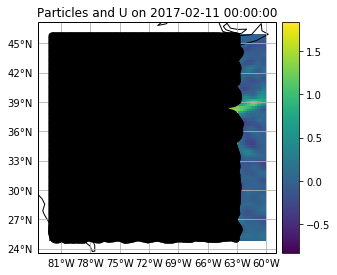

In [10]:
pset.show(field=fieldset.U)